<a href="https://colab.research.google.com/github/jaden-2/Assignment/blob/master/UNET1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive

drive.mount("/content/drive")

Mounted at /content/drive


In [2]:
import glob
import cv2
import numpy as np
import os
import skimage.io as io
import skimage.transform as trans
import numpy as np
from keras.models import *
from keras.layers import *
from keras.optimizers import *

import os

import tensorflow as tf


from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras import backend as keras
from keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
import matplotlib.pyplot as plt


%matplotlib inline
plt.rcParams['figure.figsize'] = (12, 9)

In [3]:
%cd drive/MyDrive/project

/content/drive/MyDrive/project


In [60]:
image_path_list = glob.glob("train/images/*")
X_train=[]
y_train=[]

for image_path in image_path_list[:100]:
    image = cv2.resize(cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)/255, (256, 256))
    X_train.append(image)
    mask = cv2.resize(cv2.imread(image_path.replace("images","masks"), cv2.IMREAD_GRAYSCALE)/255, (256, 256))
    y_train.append(mask)
X_train=np.array(X_train)
y_train=np.array(y_train)
X_train = np.expand_dims(X_train, axis=-1)
y_train = np.expand_dims(y_train, axis=-1)



In [6]:
def unet(pretrained_weights = None,input_size = (256,256,1)):
    inputs = Input(input_size)
    conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(inputs)
    conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool3)
    conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv4)
    drop4 = Dropout(0.5)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

    conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool4)
    conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv5)
    drop5 = Dropout(0.5)(conv5)

    up6 = Conv2D(512, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(drop5))
    merge6 = concatenate([drop4,up6], axis = 3)
    conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge6)
    conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv6)

    up7 = Conv2D(256, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv6))
    merge7 = concatenate([conv3,up7], axis = 3)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge7)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv7)

    up8 = Conv2D(128, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv7))
    merge8 = concatenate([conv2,up8], axis = 3)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge8)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv8)

    up9 = Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv8))
    merge9 = concatenate([conv1,up9], axis = 3)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge9)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv9 = Conv2D(2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv10 = Conv2D(1, 1, activation = 'sigmoid',name="output")(conv9)

    model = Model(inputs= inputs, outputs= conv10)

    model.compile(optimizer = Adam(learning_rate = 1e-4), loss = 'binary_crossentropy', metrics = ['accuracy'])

    if(pretrained_weights):
        model.load_weights(pretrained_weights)

    return model


model = unet()

In [61]:
model_checkpoint = ModelCheckpoint('unet_membrane.hdf5', monitor='loss',verbose=1, save_best_only=True)
model.fit(X_train,y_train,batch_size=3,epochs=1,callbacks=[model_checkpoint])

34/34 [==============================] - ETA: 0s - loss: 0.6762 - accuracy: 0.7188
Epoch 1: loss improved from inf to 0.67623, saving model to unet_membrane.hdf5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


34/34 [==============================] - 14s 422ms/step - loss: 0.6762 - accuracy: 0.7188


1/1 [==============================] - 0s 220ms/step


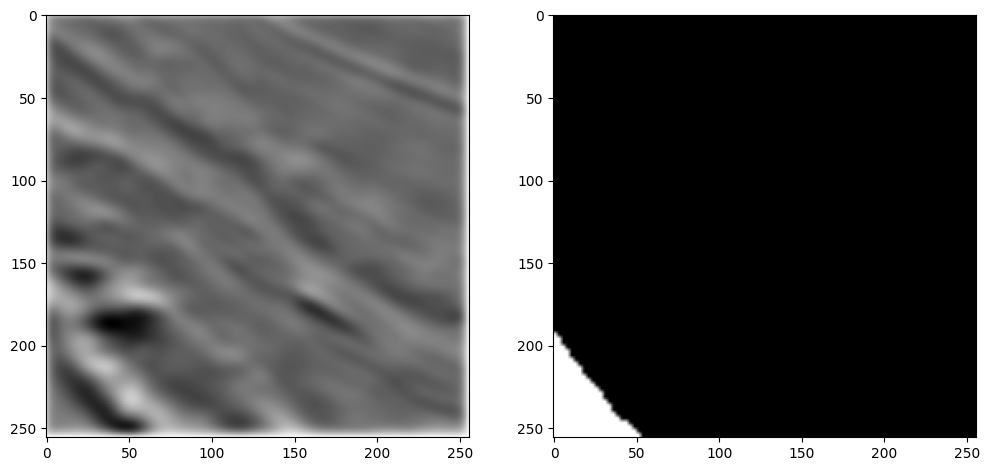

In [62]:
y_pred = model.predict(np.array([X_train[10,:,:]]))
fig, ax = plt.subplots(1, 2)
ax[0].imshow(y_pred[0,:,:,0], cmap='gray')
ax[1].imshow(y_train[10], cmap='gray')

In [ ]:
%ls

aug/  image/  label/


In [ ]:
import os

os.getcwd()

'/content/drive/MyDrive/project/unet/data/membrane'

In [63]:
class DataGenerator(tf.keras.utils.Sequence):
    def __init__(self, image_dir, mask_dir, batch_size=32, image_size=(256, 256), augment=False):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.batch_size = batch_size
        self.image_size = image_size
        self.augment = augment
        self.image_paths = sorted(os.listdir(image_dir))
        self.mask_paths = sorted(os.listdir(mask_dir))
        self.on_epoch_end()

        self.image_datagen = ImageDataGenerator(
            rescale=1./255,
            rotation_range=40,
            width_shift_range=0.2,
            height_shift_range=0.2,
            shear_range=0.2,
            zoom_range=0.2,
            horizontal_flip=True,
            fill_mode='nearest'
        ) if augment else ImageDataGenerator(rescale=1./255)

        self.mask_datagen = ImageDataGenerator(
            rescale=1./255,
            rotation_range=40,
            width_shift_range=0.2,
            height_shift_range=0.2,
            shear_range=0.2,
            zoom_range=0.2,
            horizontal_flip=True,
            fill_mode='nearest'
        ) if augment else ImageDataGenerator(rescale=1./255)

    def __len__(self):
        return int(np.floor(len(self.image_paths) / self.batch_size))

    def __getitem__(self, index):
        batch_image_paths = self.image_paths[index * self.batch_size:(index + 1) * self.batch_size]
        batch_mask_paths = self.mask_paths[index * self.batch_size:(index + 1) * self.batch_size]

        images = np.array([img_to_array(load_img(os.path.join(self.image_dir, path), color_mode="grayscale", target_size=self.image_size)) for path in batch_image_paths])
        masks = np.array([img_to_array(load_img(os.path.join(self.mask_dir, path), target_size=self.image_size, color_mode='grayscale')) for path in batch_mask_paths])

        seed = np.random.randint(0, 10000)
        if self.augment:
            images = self.image_datagen.flow(images, batch_size=self.batch_size, seed=seed).next()
            masks = self.mask_datagen.flow(masks, batch_size=self.batch_size, seed=seed).next()

        return images, masks

    def on_epoch_end(self):
        np.random.shuffle(self.image_paths)
        np.random.shuffle(self.mask_paths)


In [64]:
image_dir = "/content/drive/MyDrive/project/unet/data/membrane/train/image/"
mask_dir = "/content/drive/MyDrive/project/unet/data/membrane/train/label/"

# Create training and validation generators
train_gen = DataGenerator(image_dir, mask_dir, batch_size=20, augment=True)
val_gen = DataGenerator(image_dir, mask_dir, batch_size=20, augment=False)



In [68]:

model = unet()
model_checkpoint = ModelCheckpoint('unet_membrane.hdf5', monitor='loss',verbose=1, save_best_only=True)
model.fit(train_gen, validation_data=val_gen, batch_size=3, epochs= 20,callbacks=[model_checkpoint])


Epoch 1/20
1/1 [==============================] - ETA: 0s - loss: 0.6250 - accuracy: 0.6718
Epoch 1: loss improved from inf to 0.62500, saving model to unet_membrane.hdf5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1/1 [==============================] - 24s 24s/step - loss: 0.6250 - accuracy: 0.6718 - val_loss: -269730.2500 - val_accuracy: 0.0000e+00
Epoch 2/20
1/1 [==============================] - ETA: 0s - loss: 1.8205 - accuracy: 0.7195
Epoch 2: loss did not improve from 0.62500
1/1 [==============================] - 3s 3s/step - loss: 1.8205 - accuracy: 0.7195 - val_loss: -81871.7031 - val_accuracy: 0.0000e+00
Epoch 3/20
1/1 [==============================] - ETA: 0s - loss: 0.5771 - accuracy: 0.7257
Epoch 3: loss improved from 0.62500 to 0.57708, saving model to unet_membrane.hdf5
1/1 [==============================] - 11s 11s/step - loss: 0.5771 - accuracy: 0.7257 - val_loss: -34103.8398 - val_accuracy: 0.0000e+00
Epoch 4/20
1/1 [==============================] - ETA: 0s - loss: 0.5664 - accuracy: 0.7195
Epoch 4: loss improved from 0.57708 to 0.56637, saving model to unet_membrane.hdf5
1/1 [==============================] - 7s 7s/step - loss: 0.5664 - accuracy: 0.7195 - val_loss: -35790.77

In [69]:
test_path = "/content/drive/MyDrive/project/unet/data/membrane/test/*"

image_path = glob.glob(test_path)

x_test = []

for path in image_path:
  image = cv2.resize(cv2.imread(path, cv2.IMREAD_GRAYSCALE)/255, (256, 256))

  x_test.append(image)


x_test = np.array(x_test)
x_test = np.expand_dims(x_test, axis=-1)

In [70]:
prediction = model.predict(x_test)

2/2 [==============================] - 1s 585ms/step


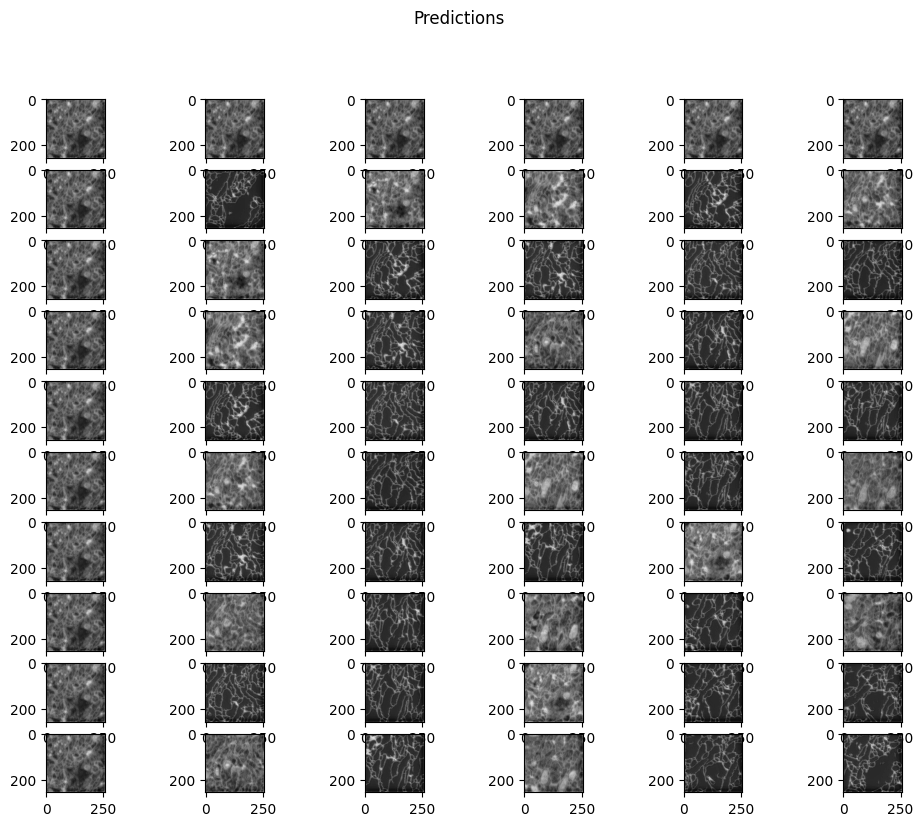

In [78]:
fig, ax = plt.subplots(10, 6)
fig.suptitle("Predictions")

for i in range(10):
  for c in range(6):
    ax[i][c].imshow(prediction[i*c], cmap= "Greys")


## Problem 2

The U-Net architecture is a convolutional network architecture made of 2 main paths


1.   Encoder: The encoder captures the context and high level features of the input image
2.   Decoder: This part of the network enables precise localization by upsampling and combining high-resolution features from the contracting path

